# WC model

## geneated data

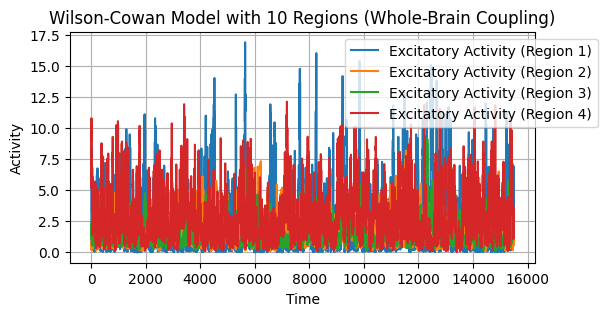

2493359643


Text(0, 0.5, 'Input Value')

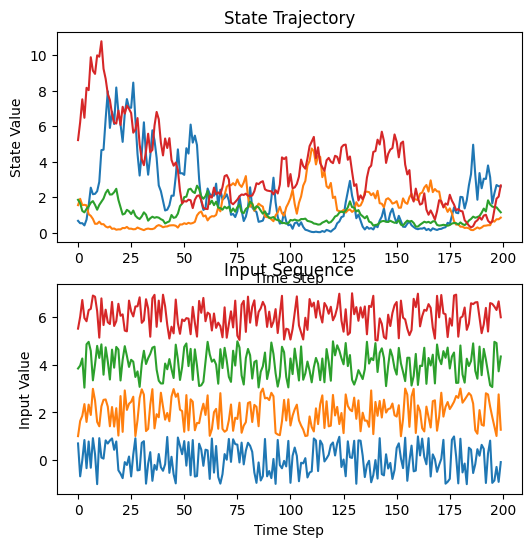

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

from utils.training_utils import dynamics_analysis, model_evaluation, return_eirnn_model_params, return_var_model_params, return_perturb_model_params
num_regions = 10   
num_states=num_regions
num_inputs = 4   
num_observed = 4
np.random.seed(800)

# Sigmoid
def sigmoid(x, a, theta):
    return 1 / (1 + np.exp(-a * (x - theta))) - 1 / (1 + np.exp(a * theta))

dt=0.05
# Wilson-Cowan model
def wilson_cowan(y, W_EE, W_EI, W_IE, W_II, r, E_tau, E_a, E_theta, I_tau, I_a, I_theta, I_ext_E, I_ext_I):
    
    num_regions = W_EE.shape[0]
    E = y[:num_regions]  #
    I = y[num_regions:]  
    
   
    input_E = W_EE @ E - W_EI @ I + I_ext_E
    E = E+dt*(-E + (1 - r * E) * sigmoid(input_E, E_a, E_theta)) / E_tau
    
 
    input_I = W_IE @ E - W_II @ I + I_ext_I
    I =I+dt* (-I + (1 - r * I) * sigmoid(input_I, I_a, I_theta)) / I_tau
    
    return np.concatenate([E, I])
    # return np.vstack((E, I)).flatten()



W_EE = np.random.rand(num_regions, num_regions) * 2  
W_EI = np.random.rand(num_regions, num_regions) * 1  
W_IE = np.random.rand(num_regions, num_regions) * 1 
W_II = np.random.rand(num_regions, num_regions) * 1  
B = 5*np.random.uniform(-3, 3, (num_regions, num_inputs))
C = np.random.uniform(-10, 10, (num_observed, num_regions))

np.fill_diagonal(W_EE, 12)
np.fill_diagonal(W_EI, 4)
np.fill_diagonal(W_IE, 13)
np.fill_diagonal(W_II, 11)

# parameters in wc model
r=1
E_tau=1
E_a=1.2
E_theta=0.1
I_tau=1
I_a=1
I_theta=0.1


E0 = np.random.rand(num_regions) * 0.1  
I0 = np.random.rand(num_regions) * 0.1 
y0 = np.vstack((E0, I0)).flatten()


t_span = (0, 100) 
t_eval = np.linspace(t_span[0], t_span[1], 1000) 


def generate_random_inputs(num_steps, num_inputs, input_min, input_max):
    
    return np.random.uniform(input_min, input_max, (num_steps, num_inputs))

num_steps = 16000  

input_min = -1
input_max = 1
# 

x = np.zeros((num_steps, num_regions*2)) 
y = np.zeros((num_steps, num_observed)) 
u = generate_random_inputs(num_steps, num_inputs, input_min, input_max)  

# state initialization
x[0, :] = np.random.uniform(-1, 1, num_regions*2)
y[0:1, :] = 3*np.log(1+np.exp(C@(x[0:1,:num_regions].T)).T)


for t in range(1, num_steps):
    # x[t, :] = np.tanh(A @ x[t-1, :] + B @ u[t, :])
    x[t, :] = wilson_cowan(x[t-1, :], W_EE, W_EI, W_IE, W_II, r, E_tau, E_a, E_theta, I_tau, I_a, I_theta, B @ u[t, :], np.zeros(num_regions))
    y[t:t+1, :] = 3*np.log(1+np.exp(C@(x[t:t+1,:num_regions].T)).T)



# plt.figure(figsize=(12, 8))
# for i in range(num_observed):
#     plt.plot(y[500:700,i], label=f"Excitatory Activity (Region {i+1})")
# plt.xlabel("Time")
# plt.ylabel("Activity")
# plt.title("Wilson-Cowan Model with 10 Regions (Whole-Brain Coupling)")
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid()
# plt.show()



plt.figure(figsize=(6, 3))
for i in range(num_observed):
    plt.plot(y[500:,i], label=f"Excitatory Activity (Region {i+1})")
plt.xlabel("Time")
plt.ylabel("Activity")
plt.title("Wilson-Cowan Model with 10 Regions (Whole-Brain Coupling)")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid()
plt.show()

state = np.random.get_state()
current_state = state[1][0]
print(current_state)

y=y[500:,:]
u=u[500:,:]
x=x[500:,:]

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
for i in range(num_observed):
    plt.plot(y[:200, i], label="State %d"%(i+1))
plt.title("State Trajectory")
plt.xlabel("Time Step")
plt.ylabel("State Value")
#plt.legend()

plt.subplot(2, 1, 2)
for i in range(4):
    plt.plot(u[:200, i]+2*i, label="Input %d"%(i+1))
plt.title("Input Sequence")
plt.xlabel("Time Step")
plt.ylabel("Input Value")
# plt.legend()

In [2]:
from utils.DataSample import Input_Data
from torch.utils.data.sampler import SubsetRandomSampler
import torch
from utils.training_utils import train_model, model_prediction_, model_prediction_forloop
from utils.Models import Latent_Model
from scipy.io import savemat, loadmat
Tp_length = 10
device = torch.device('cuda:0')
simple_params = {
                'Num_Cortical': num_states,
                'Tp': Tp_length,
                'Sample_Size': np.max(np.array(y).shape),
                'data_length': 51,  # Hyperparameter
                'input_index': 0.05,
                'with_input': True,
                'AR_order':3,
                'ext_input_dim':4
            }
input_data = Input_Data(simple_params, y.T,u.T,x.T)
#  = input_data.data_length
dataset_size = len(input_data)
print(input_data.ext_input.shape)
k_folds = 10
fold_size = dataset_size // k_folds
indices = list(range(dataset_size))

# ground truth model
model_params = return_eirnn_model_params(hidden_dim=50,data_length=simple_params['data_length'],Tp_length=Tp_length,device=device)
model_params['RNN_Type']='WC_model' # 'AR', #'GRU' ,# 'AR' #
model_params['Train_model']=False
model_params['W_EE']=W_EE.astype('float32')
model_params['W_EI']=W_EI.astype('float32')
model_params['W_IE']=W_IE.astype('float32')
model_params['W_II']=W_II.astype('float32')
model_params['dt']=dt
model_params['B']=B.astype('float32')
model_params['C']=C.astype('float32')
model_params['device']=device
model_params['HIDDEN_DIM']=W_EE.shape[0]*2
model_params['LATENT_DIM']=W_EE.shape[0]*2
model_params['ext_input_dim']=B.shape[1]
model_params['IN_DIM']=C.shape[0]
WC_model = Latent_Model(model_params).to(device)

nVAR_range_functional_dynamics_output=y
# nVAR_functional_dynamics, nVAR_range_functional_dynamics, nVAR_range_functional_dynamics_output, nVAR_original_signal = dynamics_analysis(WC_model, input_data, generate_length=50,
#                                                                                                                                           min_range=[-1,-1,-1,-1],max_range=[1,1,1,1],
#                                                                                                                                           scale=0.2,device=device)

# print(np.array(nVAR_range_functional_dynamics_output).shape)
# savemat(os.path.join(os.getcwd(), '../../')+'./result/wc_model/gt_reachable_state_space.mat', {'real_data': np.array(nVAR_range_functional_dynamics_output)})

nVAR_range_functional_dynamics_output = loadmat(os.path.join(os.getcwd(), '../../')+'./result/wc_model/gt_reachable_state_space.mat')['real_data']
print(np.array(nVAR_range_functional_dynamics_output).shape)

(15499, 4)
(400000, 4)


In [3]:
nVAR_range_functional_dynamics_output = np.array(nVAR_range_functional_dynamics_output)

## 10 fold

run_device: cuda:0
Fold 0, EIRNN model training...
[ 20/500] train_loss: 0.34451 valid_loss: 0.34740 hid_loss: 0.01499 pred_loss: 0.32952
[ 40/500] train_loss: 0.31360 valid_loss: 0.29525 hid_loss: 0.02275 pred_loss: 0.29085
[ 60/500] train_loss: 0.28941 valid_loss: 0.29352 hid_loss: 0.02053 pred_loss: 0.26888
[ 80/500] train_loss: 0.27872 valid_loss: 0.29101 hid_loss: 0.02221 pred_loss: 0.25651
[100/500] train_loss: 0.27686 valid_loss: 0.27691 hid_loss: 0.02152 pred_loss: 0.25534
[120/500] train_loss: 0.27603 valid_loss: 0.29226 hid_loss: 0.02095 pred_loss: 0.25508
[140/500] train_loss: 0.27406 valid_loss: 0.29741 hid_loss: 0.02095 pred_loss: 0.25311
[160/500] train_loss: 0.27949 valid_loss: 0.26720 hid_loss: 0.02427 pred_loss: 0.25523
[180/500] train_loss: 0.26265 valid_loss: 0.26918 hid_loss: 0.02754 pred_loss: 0.23511
[200/500] train_loss: 0.27219 valid_loss: 0.28355 hid_loss: 0.02856 pred_loss: 0.24363
Validation loss decreased (inf --> 0.268450).  Saving model ...
EarlyStopping c

/mnt/dataset1/zhichao/codes/data_driven_surrogate_guides_optimal_neural_stimulation/utils/training_utils.py:210: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,2.5))


R2: 0.8836433390976296 _std: 0.04697553618848619 

MSE: 0.2203099654186867 _std: 0.055136931742015956 

EV: 0.8892598971341524 _std: 0.043929106596752164 

CC: 0.9289684874218804 _std: 0.022798925387279474 

cuda:0
model.hidden_dim: 50


range_functional_dynamics trails:  39

(400000, 4)
Fold 5, var model training...
[ 20/500] train_loss: 2.29853 valid_loss: 2.23625 hid_loss: 1.97915 pred_loss: 0.31938
[ 40/500] train_loss: 1.73775 valid_loss: 1.70647 hid_loss: 1.41802 pred_loss: 0.31973
[ 60/500] train_loss: 1.41778 valid_loss: 1.38564 hid_loss: 1.09819 pred_loss: 0.31959
[ 80/500] train_loss: 1.20036 valid_loss: 1.18300 hid_loss: 0.88118 pred_loss: 0.31918
[100/500] train_loss: 1.03978 valid_loss: 1.02517 hid_loss: 0.72107 pred_loss: 0.31871
[120/500] train_loss: 0.91486 valid_loss: 0.91019 hid_loss: 0.59660 pred_loss: 0.31826
[140/500] train_loss: 0.81422 valid_loss: 0.81384 hid_loss: 0.49628 pred_loss: 0.31795
[160/500] train_loss: 0.73089 valid_loss: 0.72177 hid_loss: 0.41342 pred

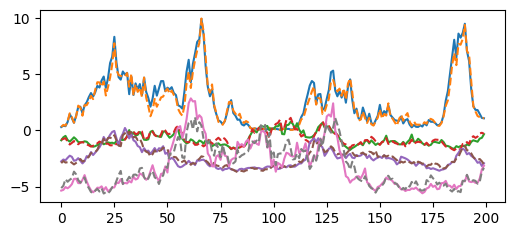

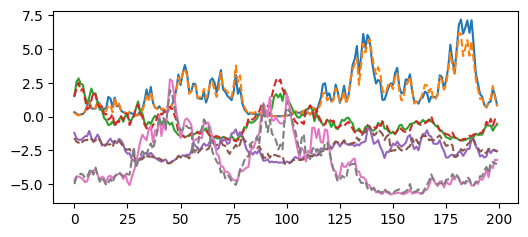

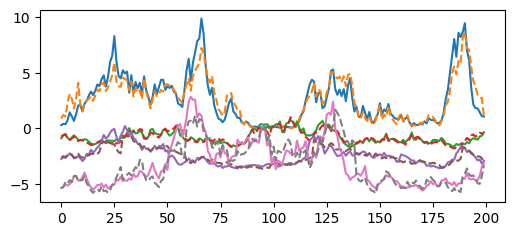

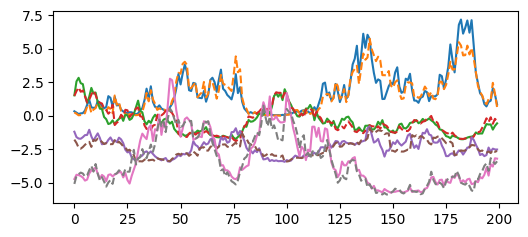

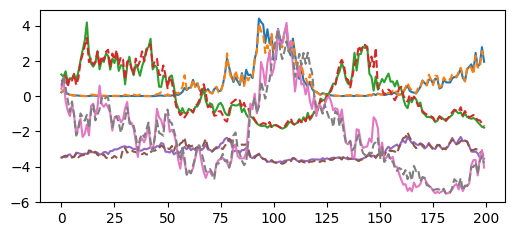

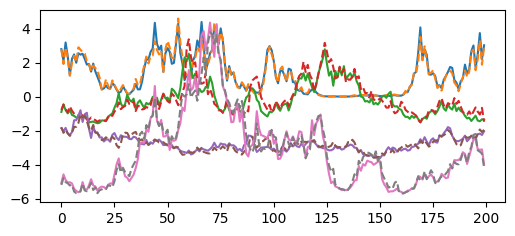

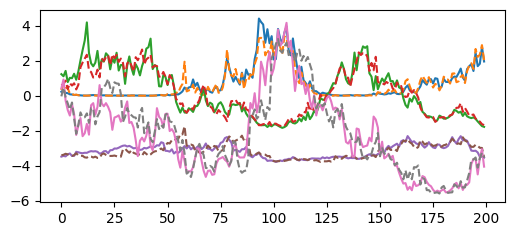

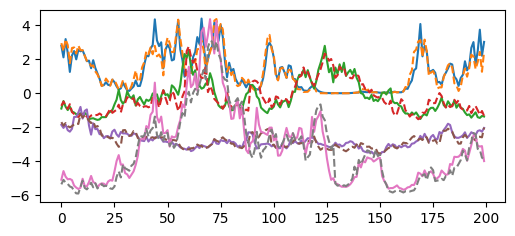

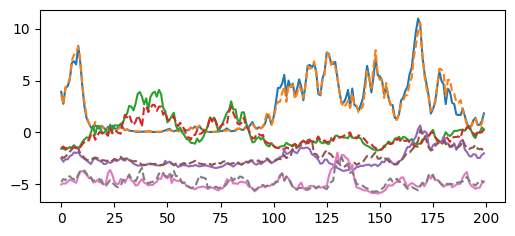

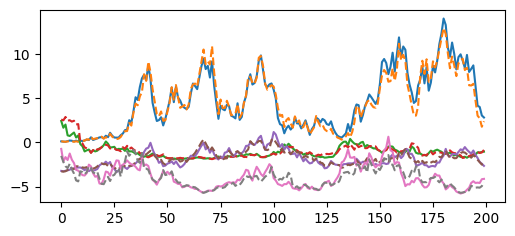

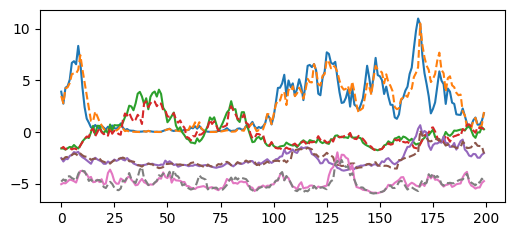

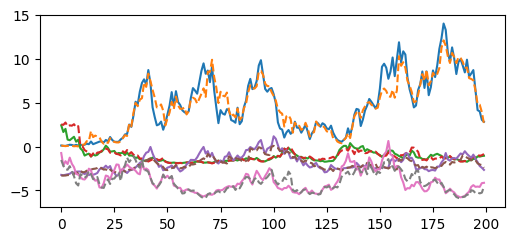

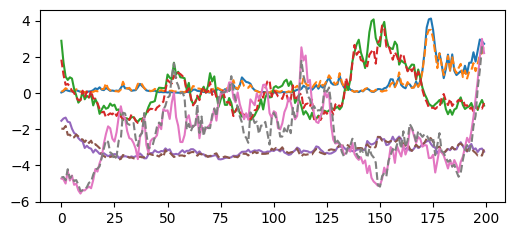

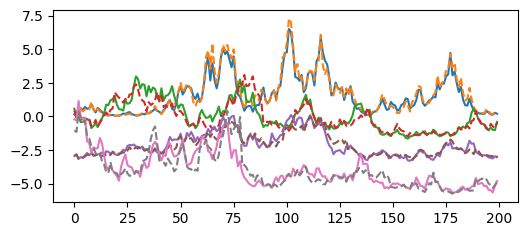

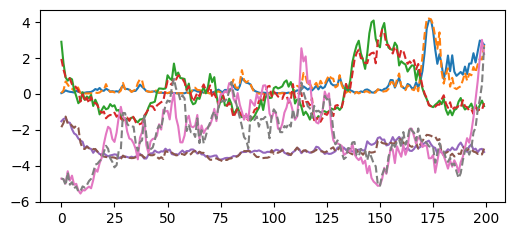

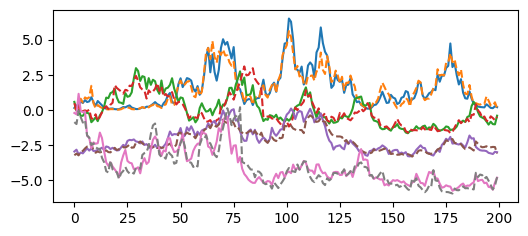

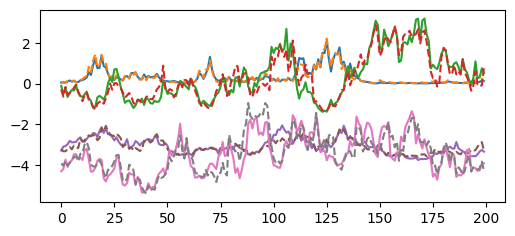

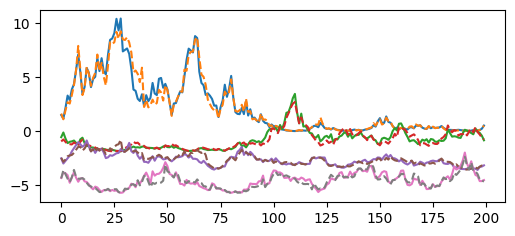

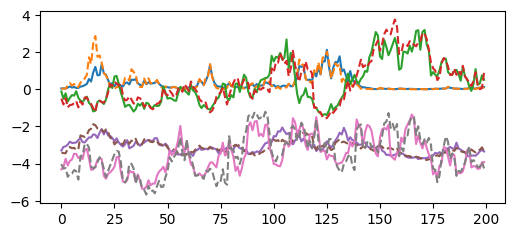

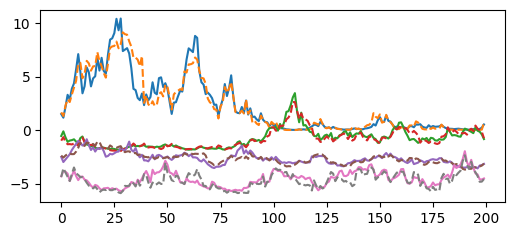

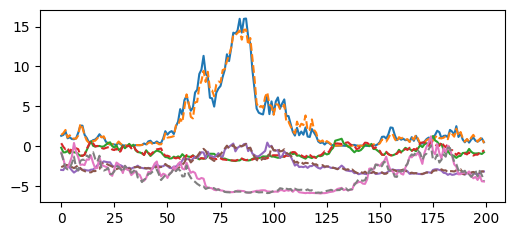

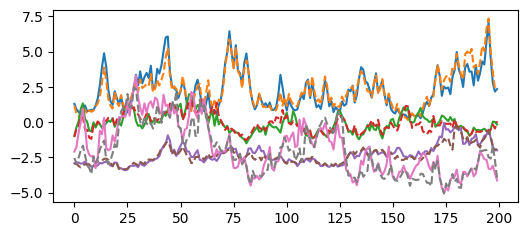

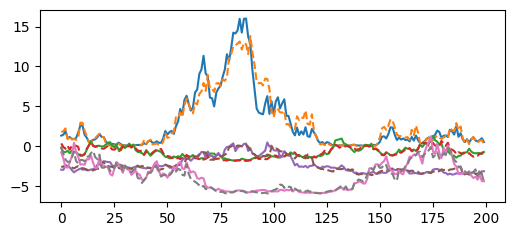

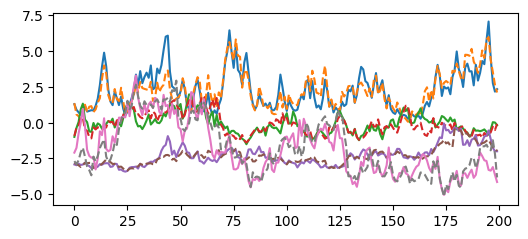

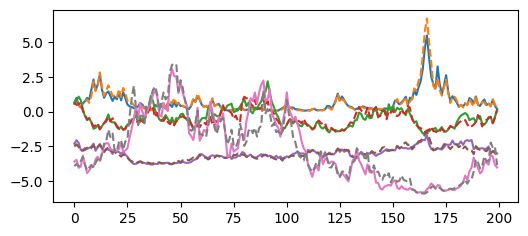

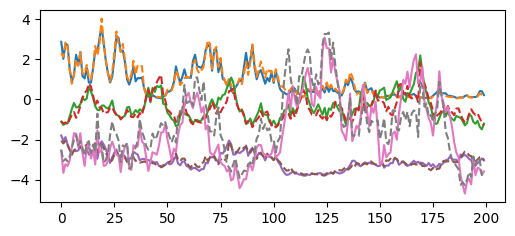

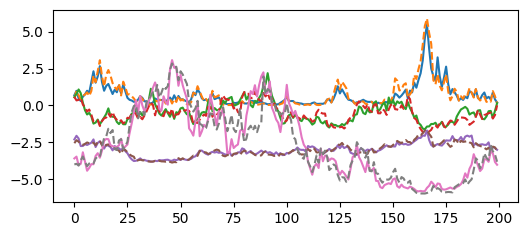

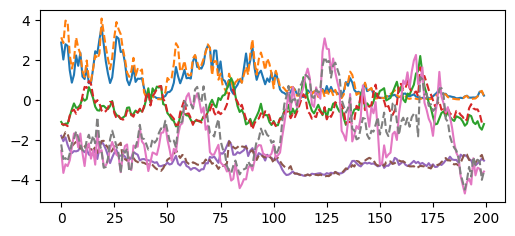

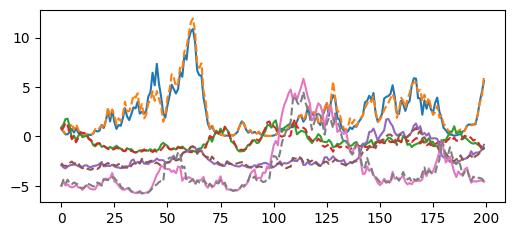

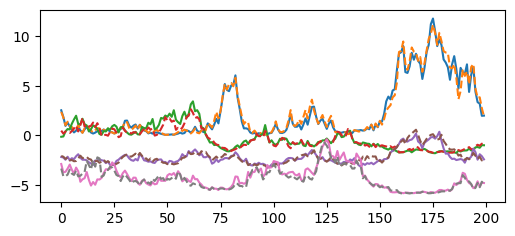

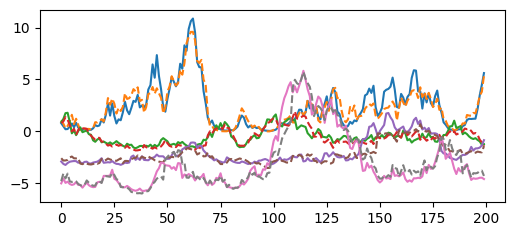

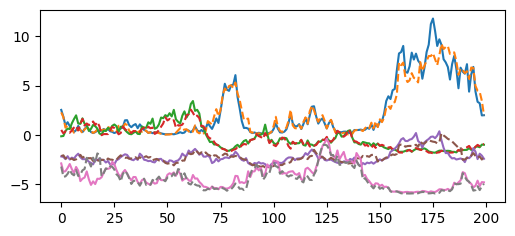

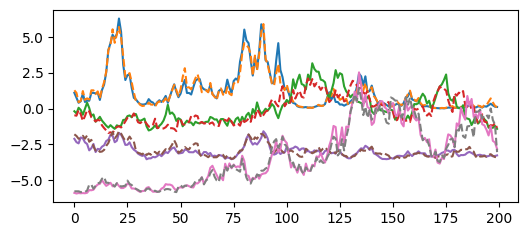

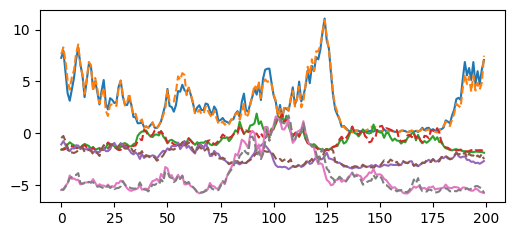

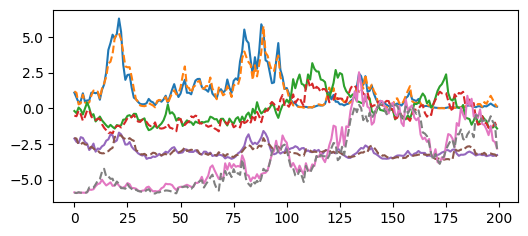

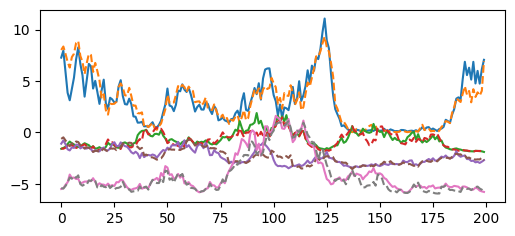

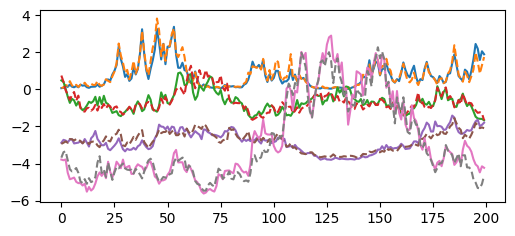

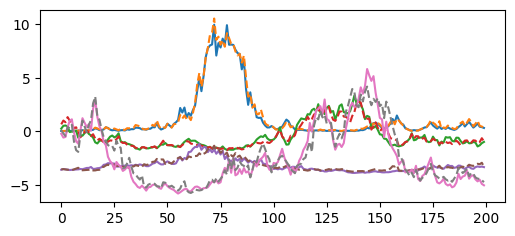

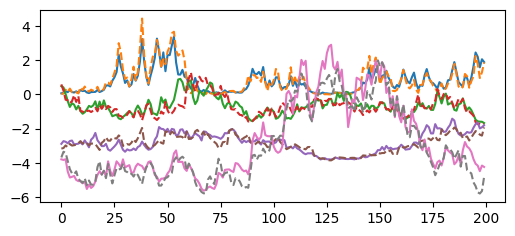

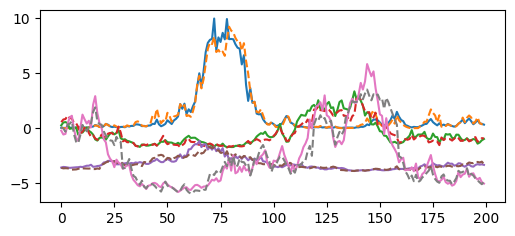

In [4]:
indices = [int(i) for i in range(dataset_size)]
# print('range_limits:',range_limits)
fold_size = int(dataset_size // k_folds)
var_range_k = []
rnn_range_k = []

for fold in range(k_folds):
    val_start = fold * fold_size
    val_end = val_start + fold_size
    val_indices = indices[val_start:val_end]
    # print(val_start,val_end)
    train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
    # print(train_indices)
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_dataloader = torch.utils.data.DataLoader(input_data, batch_size=300,
                                                    sampler=train_sampler, num_workers=4)
    validation_dataloader = torch.utils.data.DataLoader(input_data, batch_size=300,
                                                        sampler=valid_sampler)
    X, ext_in, start_indexs = next(iter(validation_dataloader))
    hidden_dim=50
    
    
    model_params = return_eirnn_model_params(hidden_dim=hidden_dim,data_length=simple_params['data_length'],Tp_length=Tp_length,device=device) # return_var_model_params
    model = Latent_Model(model_params).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
                
    epochs=500
    ckpts_eirnn = os.path.join(os.getcwd(), '../../')+'./result/wc_model/eirnn_dt_%.2f_fold_%d.pth'%(dt,fold)  # 0413 loss = 0.067
    # ckpts_var = './wc_model/var_dt_%.2f_fold_%d.pth'%(dt,fold)
    ckpts_var = os.path.join(os.getcwd(), '../../')+'./result/wc_model/y_x_var_dt_%.2f_fold_%d.pth'%(dt,fold)

    print('Fold %d, EIRNN model training...'%fold)
    #if not os.path.exists(ckpts_eirnn):
    model = train_model(model,train_dataloader,validation_dataloader,optimizer,epochs,ckpts_eirnn,device)
    model.load_state_dict(torch.load(ckpts_eirnn,map_location=device))
    statistic_result_eirnn = model_evaluation(model,input_data,start_indexs,Tp_length,device)
    
    functional_dynamics, range_functional_dynamics, range_functional_dynamics_output, original_signal = dynamics_analysis(model, input_data, generate_length=50,
                                                                                                                      min_range=[-1,-1,-1,-1],max_range=[1,1,1,1],
                                                                                                                      scale=0.2,device=device)
    rnn_range_k.append(np.array(range_functional_dynamics_output))
    print(np.array(range_functional_dynamics_output).shape)

    print('Fold %d, var model training...'%fold)
    hidden_dim=4
    var_model_params = return_var_model_params(hidden_dim=hidden_dim,data_length=simple_params['data_length'],Tp_length=Tp_length,device=device) # return_var_model_params
    var_model = Latent_Model(var_model_params).to(device)
    optimizer = torch.optim.Adam(var_model.parameters(),lr=1e-2,weight_decay=1e-4)
    #if not os.path.exists(ckpts_var):
    var_model = train_model(var_model,train_dataloader,validation_dataloader,optimizer,epochs,ckpts_var,device)
    var_model.load_state_dict(torch.load(ckpts_var,map_location=device))
    statistic_result_var = model_evaluation(var_model,input_data,start_indexs,Tp_length,device)
    functional_dynamics, range_functional_dynamics, var_model_range_functional_dynamics_output, original_signal = dynamics_analysis(var_model, input_data, generate_length=50,
                                                                                                                      min_range=[-1,-1,-1,-1],max_range=[1,1,1,1],
                                                                                                                      scale=0.2,device=device)
    
    var_range_k.append(np.array(var_model_range_functional_dynamics_output))
    print(np.array(var_model_range_functional_dynamics_output).shape)

    savemat(os.path.join(os.getcwd(), '../../')+'./result/wc_model/statistics_dt_%.2f_fold_%d.mat'%(dt,fold), {'EIRNN_statistic_result': statistic_result_eirnn,
                                                                                                                'var_statistic_result': statistic_result_var})

## Evaluation

## model statiscs 

In [5]:
import pandas as pd
from scipy.stats import mannwhitneyu, sem, ttest_ind
# EV
sta_pd = []
for fold in range(k_folds):
    sta_file = os.path.join(os.getcwd(), '../../')+'./result/wc_model/statistics_dt_%.2f_fold_%d.mat'%(dt,fold)
    sta_data = loadmat(sta_file)
    EIRNN_statistic_result = sta_data['EIRNN_statistic_result']
    var_statistic_result = sta_data['var_statistic_result']
    for name in EIRNN_statistic_result.dtype.names[:4]:
        result_ = EIRNN_statistic_result[name][0][0][0].flatten()
        sta_pd.append(pd.DataFrame({'value':result_,'model':'EIRNN','name':name,'fold':fold}))
    for name in var_statistic_result.dtype.names[:4]:
        result_ = var_statistic_result[name][0][0][0].flatten()
        sta_pd.append(pd.DataFrame({'value':result_,'model':'VAR','name':name,'fold':fold}))
    # break
sta_pd = pd.concat(sta_pd,axis=0)

In [6]:
sta_pd1 = sta_pd.groupby(['model','name','fold'])['value'].agg(['mean', sem, 'std']).reset_index()
sta_pd1


model name  fold      mean       sem       std
0   EIRNN   CC     0  0.939768  0.003024  0.016562
1   EIRNN   CC     1  0.940560  0.003199  0.017523
2   EIRNN   CC     2  0.915024  0.002666  0.014603
3   EIRNN   CC     3  0.931190  0.003793  0.020775
4   EIRNN   CC     4  0.926359  0.005240  0.028698
..    ...  ...   ...       ...       ...       ...
75    VAR  mse     5  0.362568  0.021040  0.115239
76    VAR  mse     6  0.306737  0.027474  0.150481
77    VAR  mse     7  0.414329  0.021314  0.116742
78    VAR  mse     8  0.397104  0.027198  0.148972
79    VAR  mse     9  0.354922  0.021012  0.115090

[80 rows x 6 columns]

In [7]:
sta_pd2 =  sta_pd1.groupby(['model','name'])['mean'].agg(['mean', sem, 'std']).reset_index()
sta_pd2

model name      mean       sem       std
0  EIRNN   CC  0.930265  0.002665  0.008428
1  EIRNN   EV  0.902910  0.005248  0.016596
2  EIRNN   R2  0.897771  0.005528  0.017480
3  EIRNN  mse  0.210703  0.016905  0.053459
4    VAR   CC  0.895996  0.002903  0.009180
5    VAR   EV  0.850021  0.005040  0.015939
6    VAR   R2  0.843937  0.004971  0.015720
7    VAR  mse  0.332970  0.016968  0.053657

In [8]:
data = sta_pd1[sta_pd1['name']=='EV']
data
# data_melted = data.melt(var_name='model', value_name='value')
# data_melted

model name  fold      mean       sem       std
10  EIRNN   EV     0  0.911015  0.003127  0.017130
11  EIRNN   EV     1  0.927760  0.004057  0.022222
12  EIRNN   EV     2  0.886136  0.004810  0.026346
13  EIRNN   EV     3  0.873709  0.007342  0.040212
14  EIRNN   EV     4  0.905753  0.008997  0.049278
15  EIRNN   EV     5  0.889260  0.008157  0.044680
16  EIRNN   EV     6  0.896672  0.006591  0.036101
17  EIRNN   EV     7  0.914214  0.003710  0.020323
18  EIRNN   EV     8  0.920181  0.007100  0.038887
19  EIRNN   EV     9  0.904399  0.005322  0.029149
50    VAR   EV     0  0.851686  0.004758  0.026063
51    VAR   EV     1  0.849824  0.006133  0.033589
52    VAR   EV     2  0.840579  0.005374  0.029433
53    VAR   EV     3  0.843813  0.007217  0.039527
54    VAR   EV     4  0.842816  0.012315  0.067450
55    VAR   EV     5  0.824996  0.009760  0.053457
56    VAR   EV     6  0.835732  0.006684  0.036610
57    VAR   EV     7  0.874520  0.005405  0.029603
58    VAR   EV     8  0.871114  0.008546  0.046811
59    VAR   EV     9  0.865134  0.006158  0.033731

/tmp/ipykernel_3822358/3438789166.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='mean', data=data, palette='plasma', showfliers=False, width=0.6,


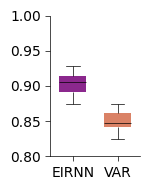

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


data = sta_pd1[sta_pd1['name']=='EV']


plt.figure(figsize=(1.6, 2))
grays_palette = ["#D3D3D3", "#A9A9A9", "#808080", "#505050"]  
sns.boxplot(x='model', y='mean', data=data, palette='plasma', showfliers=False, width=0.6,
            boxprops=dict(edgecolor='none'),  
            medianprops=dict(color='black', linewidth=0.5),
            whiskerprops=dict(color='black', linewidth=0.5),  
            capprops=dict(color='black', linewidth=0.5)) 
ax = plt.gca()
    

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xticklabels([]) 
# ax.set_yticklabels([]) 
# plt.yticks([0.2,0.3,0.4,0.5]) 
plt.xlabel('')
# plt.xlabel(r'$\hat{A}$')
plt.ylabel('')
# ax.spines['left'].set_bounds((0.18,0.5))
# ax.spines['bottom'].set_bounds((-0.2,3.2))
ax.set_ylim(0.8,1)
ax.spines['bottom'].set_linewidth(0.5)  
ax.spines['left'].set_linewidth(0.5)  
ax.tick_params(axis='x', which='both', width=0.5) 
ax.tick_params(axis='y', which='both', width=0.5) 

# plt.title('Boxplot of 4 Data Groups')
plt.tight_layout()
# plt.savefig('./result/toy_model/nonlinear_simple/boxplot_EV2_wc_model.eps')

save_path = os.path.join('.', 'data_analysis','kflod','wc_model')
if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.savefig('./data_analysis/kflod/wc_model/boxplot_EV.eps', bbox_inches='tight', transparent=True)
plt.savefig('./data_analysis/kflod/wc_model/boxplot_EV.svg', bbox_inches='tight', transparent=True)

In [10]:
from scipy.stats import ttest_ind, shapiro, mannwhitneyu

aa = data[data['model']=='EIRNN']['mean'].values
bb = data[data['model']=='VAR']['mean'].values
t_stat, p_value = ttest_ind(aa, bb)
print(f"EV T-statistic: {t_stat}, P-value: {p_value}")

EV T-statistic: 7.268458849240809, P-value: 9.338508688416387e-07


In [11]:
# # 进行 Shapiro-Wilk 正态性检验
# p_in = shapiro(aa)[1]
# p_out = shapiro(bb)[1]

# print(f"域内 P 值: {p_in:.4f}, 域外 P 值: {p_out:.4f}")

# if p_in > 0.05 and p_out > 0.05:
#     print("数据服从正态分布，可以使用 t 检验。")
# else:
#     print("数据不服从正态分布，建议使用非参数检验。")

## distance function

In [12]:
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree
from scipy.special import rel_entr

 
def fast_filter_by_min_distance(points, min_threshold=0.03, rebuild_every=10):
    
    filtered = [points[0]]
    buffer = []
    tree = cKDTree(filtered)

    for i in range(1, points.shape[0]):
        dist, _ = tree.query(points[i], k=1)
        if dist > min_threshold:
            buffer.append(points[i])
            filtered.append(points[i])
        
        # 每加入 rebuild_every 个点，就更新一次树
        if len(buffer) >= rebuild_every:
            tree = cKDTree(filtered)
            buffer = []
    
    return np.array(filtered)

from scipy.spatial import cKDTree

def chamfer_distance_fast(points_A, points_B):
    
    tree_A = cKDTree(points_A)
    tree_B = cKDTree(points_B)
    
    dist_AB, _ = tree_B.query(points_A, k=1, workers=-1) 
    dist_BA, _ = tree_A.query(points_B, k=1, workers=-1)
    
    return dist_AB.mean() + dist_BA.mean()

def hausdorff_distance_fast(points_A, points_B):

    tree_A = cKDTree(points_A)
    tree_B = cKDTree(points_B)
    
    dist_AB, _ = tree_B.query(points_A, k=1, workers=-1)
    
    dist_BA, _ = tree_A.query(points_B, k=1, workers=-1)

    return max(dist_AB.max(), dist_BA.max())

def compute_range_limits(*datasets, margin_ratio=0.005):

    all_data = np.vstack(datasets)
    mins = np.min(all_data, axis=0)
    maxs = np.max(all_data, axis=0)
    margin = (maxs - mins) * margin_ratio
    limit_list = [[float(lo), float(hi + m)] for lo, hi, m in zip(mins, maxs, margin)]
    # print(limit_list)
    return limit_list


def compute_histogram(data, bins, range_limits, epsilon=1e-10):

    hist, _ = np.histogramdd(data, bins=bins, range=range_limits, density=False)
    hist = hist.astype(np.float64)
    hist += epsilon
    hist /= np.sum(hist)
    return hist

def kl_divergence_test(P, Q, bins=20, range_limits=[0,6],epsilon=1e-10):

    bins = [bins] * P.shape[1] if isinstance(bins, int) else bins

    hist_P = compute_histogram(P, bins, range_limits, epsilon)
    hist_Q = compute_histogram(Q, bins, range_limits, epsilon)

    kl_PQ = np.sum(rel_entr(hist_P, hist_Q))
    kl_QP = np.sum(rel_entr(hist_Q, hist_P))
    return kl_PQ, kl_QP

def js_divergence(P, Q, bins=20, range_limits=[0,6],epsilon=1e-10):

    bins = [bins] * P.shape[1] if isinstance(bins, int) else bins

    hist_P = compute_histogram(P, bins, range_limits, epsilon)
    hist_Q = compute_histogram(Q, bins, range_limits, epsilon)

    hist_P /= np.sum(hist_P)
    hist_Q /= np.sum(hist_Q)
    M = 0.5 * (hist_P + hist_Q)
    JS = 0.5 * np.sum(rel_entr(hist_P, M)) + 0.5 * np.sum(rel_entr(hist_Q, M))
    return JS

from scipy.stats import wasserstein_distance

def wasserstein_distance_nd(P, Q):

    P = np.asarray(P)
    Q = np.asarray(Q)
    assert P.shape[1] == Q.shape[1], "dimension mismatch"
    dists = [
        wasserstein_distance(P[:, i], Q[:, i])
        for i in range(P.shape[1])
    ]
    return dists

## resample

In [13]:
# resampled_rnn_range_k = []
# resampled_var_range_k = []
# resampled_real_range = fast_filter_by_min_distance(nVAR_range_functional_dynamics_output, min_threshold=0.5, rebuild_every=50)
# print(resampled_real_range.shape)
# for fold in range(k_folds):
#     # 采样
#     print('Fold %d, resampling...'%fold)
#     resampled_rnn_range = fast_filter_by_min_distance(rnn_range_k[fold], min_threshold=0.5, rebuild_every=50)
#     resampled_rnn_range_k.append(resampled_rnn_range)
#     print(resampled_rnn_range.shape)
#     resampled_var_range = fast_filter_by_min_distance(var_range_k[fold], min_threshold=0.5, rebuild_every=50)
#     resampled_var_range_k.append(resampled_var_range)
#     print(resampled_var_range.shape)

## distance 计算

In [14]:
range_all = rnn_range_k+ var_range_k+ [nVAR_range_functional_dynamics_output]
bin_ranges = compute_range_limits(*range_all)
print(bin_ranges)

[[0.006812204606831074, 9.5452241897583], [0.08911067247390747, 5.34113883972168], [0.26923003792762756, 3.8846654891967773], [0.5028273463249207, 11.673833847045898]]


In [15]:
range_sta_list = []
resampled_real_range = nVAR_range_functional_dynamics_output.copy()
for fold in range(k_folds):
    print('Fold %d'%fold)
    
    kl_rnn_1, kl_rnn_2 = kl_divergence_test(nVAR_range_functional_dynamics_output,rnn_range_k[fold],bins=30, range_limits=bin_ranges)
    print(f"Fold {fold}: rnn kl1 {kl_rnn_1}, kl1 {kl_rnn_2}")
    kl_var_1, kl_var_2 = kl_divergence_test(nVAR_range_functional_dynamics_output,var_range_k[fold],bins=30, range_limits=bin_ranges)
    print(f"Fold {fold}: var kl1 {kl_var_1}, kl1 {kl_var_2}")


    # resampled_rnn_range = resampled_rnn_range_k[fold]
    resampled_rnn_range = rnn_range_k[fold]
    # print(resampled_rnn_range.shape)
    # resampled_var_range = resampled_var_range_k[fold]
    resampled_var_range = var_range_k[fold]
    # print(resampled_var_range.shape)

    # calculating the Chamer distance
    chamfer_rnn = chamfer_distance_fast(resampled_real_range,resampled_rnn_range)
    print(f"Fold {fold}: Chamfer_Distance_rnn {chamfer_rnn}")
    chamfer_var = chamfer_distance_fast(resampled_real_range,resampled_var_range)
    print(f"Fold {fold}: Chamfer_Distance_var {chamfer_var}")

    # calculating the Hausdorff distance
    hausdorff_rnn = hausdorff_distance_fast(resampled_real_range,resampled_rnn_range)
    print(f"Fold {fold}: Hausdorff_Distance_rnn {hausdorff_rnn}")
    hausdorff_var = hausdorff_distance_fast(resampled_real_range,resampled_var_range)
    print(f"Fold {fold}: Hausdorff_Distance_var {hausdorff_var}")

    # calculating the wasserstein distance
    wasserstein_rnn_ = wasserstein_distance_nd(resampled_real_range,resampled_rnn_range)
    wasserstein_rnn = np.sum(wasserstein_rnn_)
    print(f"Fold {fold}: Wasserstein_Distance_rnn {wasserstein_rnn}")
    wasserstein_var_ = wasserstein_distance_nd(resampled_real_range,resampled_var_range)
    wasserstein_var = np.sum(wasserstein_var_)
    print(f"Fold {fold}: Wasserstein_Distance_var {np.sum(wasserstein_var)}")

    
    range_sta_list.append(pd.DataFrame({'fold':[fold],'kl1':[kl_rnn_1],'kl2':[kl_rnn_2],'chamfer_rnn':[chamfer_rnn],'chamfer_var':[chamfer_var],
                                        'hausdorff_rnn':[hausdorff_rnn],'hausdorff_var':[hausdorff_var],'wasserstein_rnn':[wasserstein_rnn],'wasserstein_var':[wasserstein_var],
                                        'kl1_var':[kl_var_1],'kl2_var':[kl_var_2]}))
    print()

Fold 0
Fold 0: rnn kl1 6.739084125834593, kl1 3.1101886506859624
Fold 0: var kl1 7.619633168510882, kl1 3.3390802257618146
Fold 0: Chamfer_Distance_rnn 0.17465675876098938


Fold 0: Chamfer_Distance_var 0.18824678181320847
Fold 0: Hausdorff_Distance_rnn 1.5393731090516598
Fold 0: Hausdorff_Distance_var 1.8136625026446949
Fold 0: Wasserstein_Distance_rnn 0.19257281286818909
Fold 0: Wasserstein_Distance_var 0.15065847082338413

Fold 1
Fold 1: rnn kl1 5.845216696623797, kl1 3.0458108184215495
Fold 1: var kl1 7.860526060684632, kl1 3.392126832313789
Fold 1: Chamfer_Distance_rnn 0.16709826288759774
Fold 1: Chamfer_Distance_var 0.1913999423070013
Fold 1: Hausdorff_Distance_rnn 1.417390257288731
Fold 1: Hausdorff_Distance_var 1.9108137248102013
Fold 1: Wasserstein_Distance_rnn 0.21193276375384534
Fold 1: Wasserstein_Distance_var 0.1552395600000373

Fold 2
Fold 2: rnn kl1 7.661046390981303, kl1 3.341081129757502
Fold 2: var kl1 7.418564438342883, kl1 3.450274995882639
Fold 2: Chamfer_Distance_rnn 0.1768973517116609
Fold 2: Chamfer_Distance_var 0.18929195421375616
Fold 2: Hausdorff_Distance_rnn 1.8772508089315392
Fold 2: Hausdorff_Distance_var 1.8966923759153667
Fo

In [16]:
range_sta_pd = pd.concat(range_sta_list,axis=0).reset_index(drop=True)

### KL

/tmp/ipykernel_3822358/1129332230.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='kl', data=data_melted, palette='plasma', showfliers=False, width=0.6,


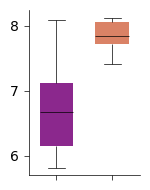

In [17]:

data = pd.DataFrame({
    'EI RNN': range_sta_pd['kl1'].values,
    'VAR': range_sta_pd['kl1_var'].values,
})


data_melted = data.melt(var_name='Model', value_name='kl')


plt.figure(figsize=(1.6, 2))
grays_palette = ["#D3D3D3", "#A9A9A9", "#808080", "#505050"]  
sns.boxplot(x='Model', y='kl', data=data_melted, palette='plasma', showfliers=False, width=0.6,
            boxprops=dict(edgecolor='none'), 
            medianprops=dict(color='black', linewidth=0.5),
            whiskerprops=dict(color='black', linewidth=0.5),  
            capprops=dict(color='black', linewidth=0.5)) 
ax = plt.gca()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([]) 
# ax.set_yticklabels([]) 
# plt.yticks([0.2,0.3,0.4,0.5]) 
plt.xlabel('')
plt.ylabel('')
# ax.spines['left'].set_bounds((0.18,0.5))
# ax.spines['bottom'].set_bounds((-0.2,3.2))
# ax.set_ylim(9,17)
ax.spines['bottom'].set_linewidth(0.5)  
ax.spines['left'].set_linewidth(0.5)  
ax.tick_params(axis='x', which='both', width=0.5)  
ax.tick_params(axis='y', which='both', width=0.5)  

plt.tight_layout()
save_path = os.path.join('.', 'data_analysis','kflod','wc_model')
if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.savefig('./data_analysis/kflod/wc_model/boxplot_kl.eps', bbox_inches='tight', transparent=True)
plt.savefig('./data_analysis/kflod/wc_model/boxplot_kl.svg', bbox_inches='tight', transparent=True)


In [18]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(range_sta_pd['kl1'].values, range_sta_pd['kl1_var'].values)
print(f"KL T-statistic: {t_stat}, P-value: {p_value}")

t_stat, p_value = mannwhitneyu(range_sta_pd['kl1'].values, range_sta_pd['kl1_var'].values)
print(f"KL U-statistic: {t_stat}, P-value: {p_value}")

KL T-statistic: -4.4682738168983995, P-value: 0.0002970862441870406
KL U-statistic: 9.0, P-value: 0.0022022199424970783


In [ ]:
# # 进行 Shapiro-Wilk 正态性检验
# p_in = shapiro(range_sta_pd['kl1'].values)[1]
# p_out = shapiro(range_sta_pd['kl1_var'].values)[1]

# print(f"域内 P 值: {p_in:.4f}, 域外 P 值: {p_out:.4f}")

# if p_in > 0.05 and p_out > 0.05:
#     print("数据服从正态分布，可以使用 t 检验。")
# else:
#     print("数据不服从正态分布，建议使用非参数检验。")

域内 P 值: 0.4511, 域外 P 值: 0.0741
数据服从正态分布，可以使用 t 检验。


### Chamfer

/tmp/ipykernel_3822358/1123569868.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='chamfer', data=data_melted, palette='plasma', showfliers=False, width=0.6,


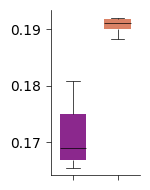

In [ ]:

data = pd.DataFrame({
    'EI RNN': range_sta_pd['chamfer_rnn'].values,
    'VAR': range_sta_pd['chamfer_var'].values,
})


data_melted = data.melt(var_name='Model', value_name='chamfer')


plt.figure(figsize=(1.6, 2))
grays_palette = ["#D3D3D3", "#A9A9A9", "#808080", "#505050"]  
sns.boxplot(x='Model', y='chamfer', data=data_melted, palette='plasma', showfliers=False, width=0.6,
            boxprops=dict(edgecolor='none'),  
            medianprops=dict(color='black', linewidth=0.5),
            whiskerprops=dict(color='black', linewidth=0.5), 
            capprops=dict(color='black', linewidth=0.5)) 
ax = plt.gca()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([]) 
# ax.set_yticklabels([]) 
# plt.yticks([0.2,0.3,0.4,0.5]) 
plt.xlabel('')
plt.ylabel('')
# ax.spines['left'].set_bounds((0.18,0.5))
# ax.spines['bottom'].set_bounds((-0.2,3.2))
# ax.set_ylim(0.25,0.34)
ax.spines['bottom'].set_linewidth(0.5)  
ax.spines['left'].set_linewidth(0.5)  
ax.tick_params(axis='x', which='both', width=0.5) 
ax.tick_params(axis='y', which='both', width=0.5) 

plt.tight_layout()
save_path = os.path.join('.', 'data_analysis','kflod','wc_model')
if not os.path.exists(save_path):
    os.makedirs(save_path)
# plt.savefig('./data_analysis/kflod/wc_model/boxplot_chamfer.eps', bbox_inches='tight', transparent=True)
# plt.savefig('./data_analysis/kflod/wc_model/boxplot_chamfer.svg', bbox_inches='tight', transparent=True)

In [21]:
t_stat, p_value = ttest_ind(range_sta_pd['chamfer_rnn'].values, range_sta_pd['chamfer_var'].values)
print(f"KL T-statistic: {t_stat}, P-value: {p_value}")

t_stat, p_value = mannwhitneyu(range_sta_pd['chamfer_rnn'].values, range_sta_pd['chamfer_var'].values)
print(f"KL U-statistic: {t_stat}, P-value: {p_value}")

KL T-statistic: -10.679690162515085, P-value: 3.2163423874185746e-09
KL U-statistic: 0.0, P-value: 0.00018267179110955002


### hausdorff

/tmp/ipykernel_3822358/81992462.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='value', data=data_melted, palette='plasma', showfliers=False, width=0.6,


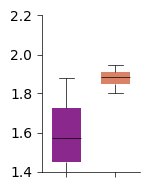

In [ ]:
# hausdorff 
data = pd.DataFrame({
    'EI RNN': range_sta_pd['hausdorff_rnn'].values,
    'VAR': range_sta_pd['hausdorff_var'].values,
})


data_melted = data.melt(var_name='Model', value_name='value')


plt.figure(figsize=(1.6, 2))
grays_palette = ["#D3D3D3", "#A9A9A9", "#808080", "#505050"]  
sns.boxplot(x='Model', y='value', data=data_melted, palette='plasma', showfliers=False, width=0.6,
            boxprops=dict(edgecolor='none'),  
            medianprops=dict(color='black', linewidth=0.5),
            whiskerprops=dict(color='black', linewidth=0.5), 
            capprops=dict(color='black', linewidth=0.5)) 
ax = plt.gca()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([]) 
# ax.set_yticklabels([]) 
# plt.yticks([0.2,0.3,0.4,0.5]) 
plt.xlabel('')
plt.ylabel('')
# ax.spines['left'].set_bounds((0.18,0.5))
# ax.spines['bottom'].set_bounds((-0.2,3.2))
ax.set_ylim(1.4,2.2)
ax.spines['bottom'].set_linewidth(0.5) 
ax.spines['left'].set_linewidth(0.5)
ax.tick_params(axis='x', which='both', width=0.5)  
ax.tick_params(axis='y', which='both', width=0.5) 

plt.tight_layout()
save_path = os.path.join('.', 'data_analysis','kflod','wc_model')
if not os.path.exists(save_path):
    os.makedirs(save_path)
# plt.savefig('./data_analysis/kflod/wc_model/boxplot_hausdorff.eps', bbox_inches='tight', transparent=True)
plt.savefig('./data_analysis/kflod/wc_model/boxplot_hausdorff.svg', bbox_inches='tight', transparent=True)

In [24]:
t_stat, p_value = ttest_ind(range_sta_pd['hausdorff_rnn'].values, range_sta_pd['hausdorff_var'].values)
print(f"KL T-statistic: {t_stat}, P-value: {p_value}")

t_stat, p_value = mannwhitneyu(range_sta_pd['hausdorff_rnn'].values, range_sta_pd['hausdorff_var'].values)
print(f"KL U-statistic: {t_stat}, P-value: {p_value}")

KL T-statistic: -4.5687917327748355, P-value: 0.00023804244171378176
KL U-statistic: 9.0, P-value: 0.0022022199424970783


### wasserstein_distance_nd

/tmp/ipykernel_3822358/2855576195.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='value', data=data_melted, palette='plasma', showfliers=False, width=0.6,


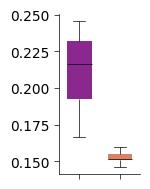

In [26]:

data = pd.DataFrame({
    'EI RNN': range_sta_pd['wasserstein_rnn'].values,
    'VAR': range_sta_pd['wasserstein_var'].values,
})


data_melted = data.melt(var_name='Model', value_name='value')


plt.figure(figsize=(1.6, 2))
grays_palette = ["#D3D3D3", "#A9A9A9", "#808080", "#505050"]  
sns.boxplot(x='Model', y='value', data=data_melted, palette='plasma', showfliers=False, width=0.6,
            boxprops=dict(edgecolor='none'),  
            medianprops=dict(color='black', linewidth=0.5),
            whiskerprops=dict(color='black', linewidth=0.5),  
            capprops=dict(color='black', linewidth=0.5))  
ax = plt.gca()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([]) 
# ax.set_yticklabels([]) 
# plt.yticks([0.2,0.3,0.4,0.5]) 
plt.xlabel('')
plt.ylabel('')
# ax.spines['left'].set_bounds((0.18,0.5))
# ax.spines['bottom'].set_bounds((-0.2,3.2))
# ax.set_ylim(1.4,2.2)
ax.spines['bottom'].set_linewidth(0.5)  
ax.spines['left'].set_linewidth(0.5) 
ax.tick_params(axis='x', which='both', width=0.5)  
ax.tick_params(axis='y', which='both', width=0.5)  

plt.tight_layout()
save_path = os.path.join('.', 'data_analysis','kflod','nonlinear_model')
if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.savefig('./data_analysis/kflod/wc_model/boxplot_wasserstein.eps', bbox_inches='tight', transparent=True)
plt.savefig('./data_analysis/kflod/wc_model/boxplot_wasserstein.svg', bbox_inches='tight', transparent=True)


In [28]:
t_stat, p_value = ttest_ind(range_sta_pd['wasserstein_rnn'].values, range_sta_pd['wasserstein_var'].values)
print(f"KL T-statistic: {t_stat}, P-value: {p_value}")

t_stat, p_value = mannwhitneyu(range_sta_pd['wasserstein_rnn'].values, range_sta_pd['wasserstein_var'].values)
print(f"KL U-statistic: {t_stat}, P-value: {p_value}")

KL T-statistic: 6.677927779667287, P-value: 2.8981153415995247e-06
KL U-statistic: 100.0, P-value: 0.00018267179110955002


## kde

In [ ]:

import random

fold = 3
selected_indices = random.sample(range(1, nVAR_range_functional_dynamics_output.shape[0]), 5000)
surrogate_data_ = rnn_range_k[fold][selected_indices,:]

selected_indices = random.sample(range(1, nVAR_range_functional_dynamics_output.shape[0]), 5000)
ori_data_ = nVAR_range_functional_dynamics_output[selected_indices,:]

selected_indices = random.sample(range(1, nVAR_range_functional_dynamics_output.shape[0]), 5000)
var_surrogate_data_ = var_range_k[fold][selected_indices,:]

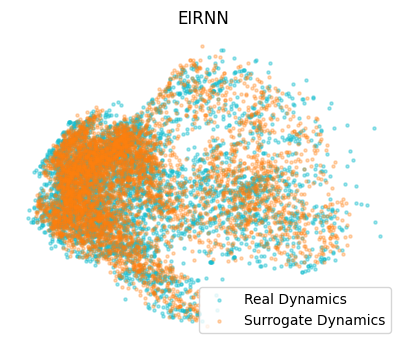

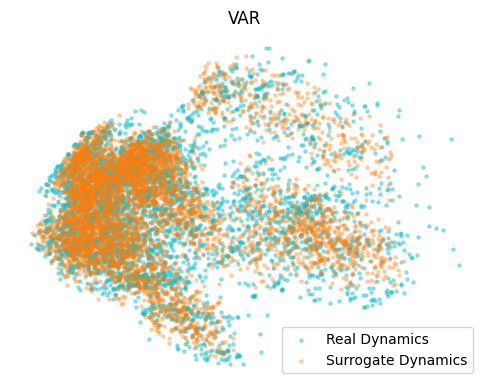

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
# proj to 2d
def plot_2d_projection(points_A, points_B, points_C):
    pca = PCA(n_components=2)
    points_A_2d = pca.fit_transform(points_A)
    points_B_2d = pca.transform(points_B)
    points_C_2d = pca.transform(points_C)
    g = plt.figure(figsize=(5,4))
    plt.scatter(points_A_2d[:, 0], points_A_2d[:, 1], c="#17becf",s=5, label="Real Dynamics", alpha=0.4)
    plt.scatter(points_B_2d[:, 0], points_B_2d[:, 1], c="#ff7f0e",s=5, label="Surrogate Dynamics", alpha=0.3)
    plt.legend()
    ax = plt.gca()
    

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # g.ax_joint.legend().remove()
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_title('EIRNN')
    # plt.show()

    g = plt.figure(figsize=(5,4))
    plt.scatter(points_A_2d[:, 0], points_A_2d[:, 1], c="#17becf",s=5, label="Real Dynamics", alpha=0.4)
    plt.scatter(points_C_2d[:, 0], points_C_2d[:, 1], c="#ff7f0e",s=5, label="Surrogate Dynamics", alpha=0.3)
    plt.legend()
    ax = plt.gca()
    

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # g.ax_joint.legend().remove()
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_title('VAR')
    plt.tight_layout()
    return points_A_2d, points_B_2d, points_C_2d

points_A_2d, points_B_2d, points_C_2d = plot_2d_projection(ori_data_, surrogate_data_,var_surrogate_data_)


In [31]:
# blue_cmap

In [32]:
# orange_cmap

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


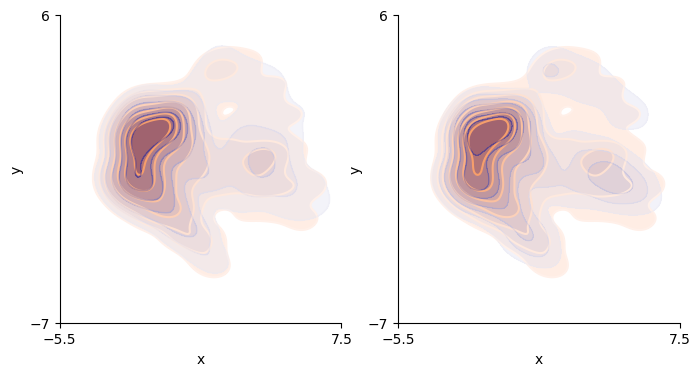

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Real Dynamics
real_x = points_A_2d[:,0] 
real_y = points_A_2d[:,1] 

# Surrogate Dynamics
surrogate_x = points_B_2d[:,0] 
surrogate_y = points_B_2d[:,1] 

# Surrogate Dynamics
surrogate_var_x = points_C_2d[:,0] 
surrogate_var_y = points_C_2d[:,1] 


data_part1 = pd.DataFrame({
    'x': real_x,  
    'y': real_y,
})

data_part2 = pd.DataFrame({
    'x': surrogate_x,  
    'y': surrogate_y,
})

data_part3 = pd.DataFrame({
    'x': surrogate_var_x,  
    'y': surrogate_var_y,
})

blue_cmap = LinearSegmentedColormap.from_list('custom_blues', ['#E9E9F4', '#0D0887']) 
orange_cmap = LinearSegmentedColormap.from_list('custom_orange', ['#FFF0E9', '#F48849']) 

#
plt.figure(figsize=(8, 4))
plt.subplot(121)

sns.kdeplot(data=data_part1, x='x', y='y', cmap=orange_cmap, fill=True, alpha=1, levels=8)
sns.kdeplot(data=data_part1,x='x',y='y',cmap=orange_cmap,fill=False,levels=8,linewidths=1.5,alpha=1) #1.5


sns.kdeplot(data=data_part2, x='x', y='y', cmap=blue_cmap, fill=True, alpha=0.4, levels=8) 
sns.kdeplot(data=data_part2,x='x',y='y',cmap=blue_cmap,fill=False,levels=8,linewidths=1.2,alpha=0.4) # 1.2


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(-7,6)
ax.set_xlim(-5.5,7.5)
ax.set_yticks([-7,6])
ax.set_xticks([-5.5,7.5])

# save_path = os.path.join('.', 'data_analysis','sys1_1')
# if not os.path.exists(save_path):
#     os.makedirs(save_path)
# plt.savefig(f"{save_path}/kde_non_rnn_s1.svg", bbox_inches = 'tight', transparent=True)
# plt.savefig(f"{save_path}/kde_non_rnn_s1.eps", bbox_inches = 'tight', transparent=True)

plt.subplot(122)

sns.kdeplot(data=data_part1, x='x', y='y', cmap=orange_cmap, fill=True, alpha=1, levels=8)#,zorder=1)
sns.kdeplot(data=data_part1,x='x',y='y',cmap=orange_cmap,fill=False,levels=8,linewidths=1.5,alpha=1)#,zorder=2)

sns.kdeplot(data=data_part3, x='x', y='y', cmap=blue_cmap, fill=True, alpha=0.4, levels=8)#,zorder=1)
sns.kdeplot(data=data_part3,x='x',y='y',cmap=blue_cmap,fill=False,levels=8,linewidths=1,alpha=0.4)#,zorder=2)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(-7,6)
ax.set_xlim(-5.5,7.5)
ax.set_yticks([-7,6])
ax.set_xticks([-5.5,7.5])

save_path = os.path.join('.', 'data_analysis','kflod','wc_model')
if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.savefig('./data_analysis/kflod/wc_model/kdeplot.eps', bbox_inches='tight', transparent=True)